Loading Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


Loading the Dataset

In [2]:
!kaggle datasets download -d yasserh/customer-segmentation-dataset

Dataset URL: https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset
License(s): CC0-1.0
 87% 19.0M/21.8M [00:00<00:00, 59.0MB/s]
100% 21.8M/21.8M [00:00<00:00, 55.8MB/s]


In [3]:
import zipfile
zipfile_path = '/content/customer-segmentation-dataset.zip'
csv_file = zipfile_path.replace('zip', '')
with zipfile.ZipFile(zipfile_path, 'r') as file:
  file.extractall()
  print('Done')

Done


In [4]:
df=pd.read_excel('/content/Online Retail.xlsx')

df.to_csv('Online Retail.csv', index=False)

In [7]:
#df=pd.read_csv('/content/Online Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [10]:
df=df.dropna()

In [12]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [13]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [17]:
# Check for duplicates
duplicates = df.duplicated().sum()

# Check for missing values
missing_values = df.isnull().sum()

# Check data types
data_types = df.dtypes

# Summary statistics for numerical columns
summary_stats = df.describe()

# Display results
print("Missing Values:\n", missing_values)
print("\nDuplicates: ", duplicates)
print("\nData Types:\n", data_types)
print("\nSummary Statistics:\n", summary_stats)

Missing Values:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Duplicates:  5225

Data Types:
 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Summary Statistics:
             Quantity                    InvoiceDate      UnitPrice  \
count  406829.000000                         406829  406829.000000   
mean       12.061303  2011-07-10 16:30:57.879207424       3.460471   
min    -80995.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-06 15:02:00       1.250000   
50%         5.000000            2011-07-31 11:48:00       1.950000   
75%        12.000000            2011-10-20 13:06:00       3.750000   
max     80995.000000            201

Feature Engineering

In [18]:
# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create 'TotalPrice' feature
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Extract temporal features from 'InvoiceDate'
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.weekday

# Handle any negative quantities or prices (if they exist)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Aggregate features at the customer level
customer_agg = df.groupby('CustomerID').agg(
    TotalSpend=('TotalPrice', 'sum'),
    TotalPurchases=('InvoiceNo', 'nunique'),
    AverageBasketSize=('Quantity', 'mean'),
    Recency=('InvoiceDate', lambda x: (df['InvoiceDate'].max() - x.max()).days),
    Frequency=('InvoiceNo', 'count'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

# Check the aggregated customer data
print(customer_agg.head())


   CustomerID  TotalSpend  TotalPurchases  AverageBasketSize  Recency  \
0     12346.0    77183.60               1       74215.000000      325   
1     12347.0     4310.00               7          13.505495        1   
2     12348.0     1797.24               4          75.516129       74   
3     12349.0     1757.55               1           8.643836       18   
4     12350.0      334.40               1          11.588235      309   

   Frequency  Monetary  
0          1  77183.60  
1        182   4310.00  
2         31   1797.24  
3         73   1757.55  
4         17    334.40  


Data Cleaning

In [19]:
# Remove any rows with negative or zero quantities and prices
df_cleaned = df[df['Quantity'] > 0]
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]

# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()

# Check the shape of the cleaned dataset
print("Cleaned Data Shape: ", df_cleaned.shape)


Cleaned Data Shape:  (392692, 14)


Cheking for Outliers

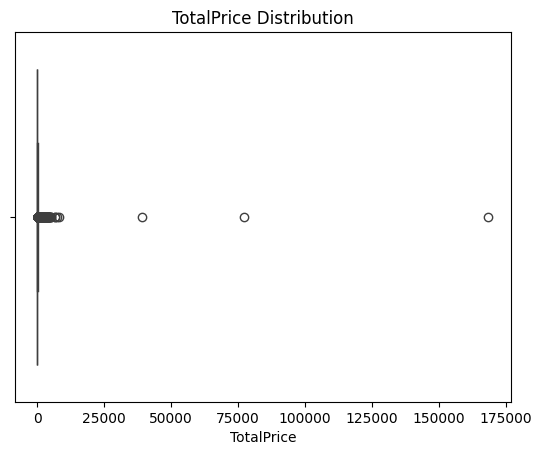

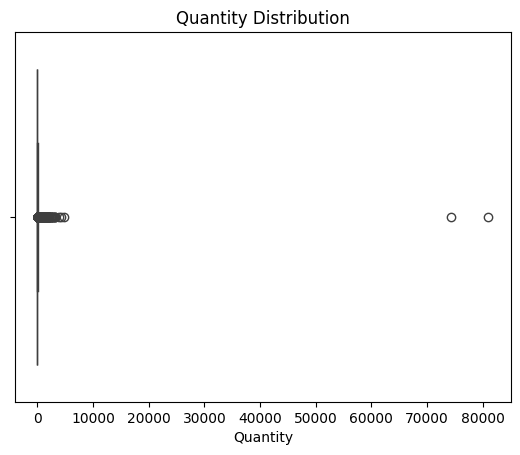

In [22]:

# Visualize outliers in 'TotalPrice' and 'Quantity'
sns.boxplot(x=df_cleaned['TotalPrice'])
plt.title('TotalPrice Distribution')
plt.show()

sns.boxplot(x=df_cleaned['Quantity'])
plt.title('Quantity Distribution')
plt.show()


# Customer Segmentation using clustering

Normalization

In [23]:
from sklearn.preprocessing import StandardScaler

# Select the relevant columns for clustering
customer_features = customer_agg[['TotalSpend', 'TotalPurchases', 'AverageBasketSize', 'Recency', 'Frequency', 'Monetary']]

# Standardize the data
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_features)

# Check the scaled data
print(customer_scaled[:5])


[[ 8.35866818e+00 -4.25096503e-01  6.16388071e+01  2.33457414e+00
  -3.96577702e-01  8.35866818e+00]
 [ 2.50966264e-01  3.54416797e-01 -2.62279345e-02 -9.05340320e-01
   3.94648958e-01  2.50966264e-01]
 [-2.85960063e-02 -3.53398530e-02  2.53059056e-02 -1.75359593e-01
  -2.65435162e-01 -2.85960063e-02]
 [-3.30117987e-02 -4.25096503e-01 -3.02682085e-02 -7.35344808e-01
  -8.18356055e-02 -3.30117987e-02]
 [-1.91347273e-01 -4.25096503e-01 -2.78212697e-02  2.17457836e+00
  -3.26635014e-01 -1.91347273e-01]]


Apply K-Means Clustering

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_scaled, kmeans.labels_))




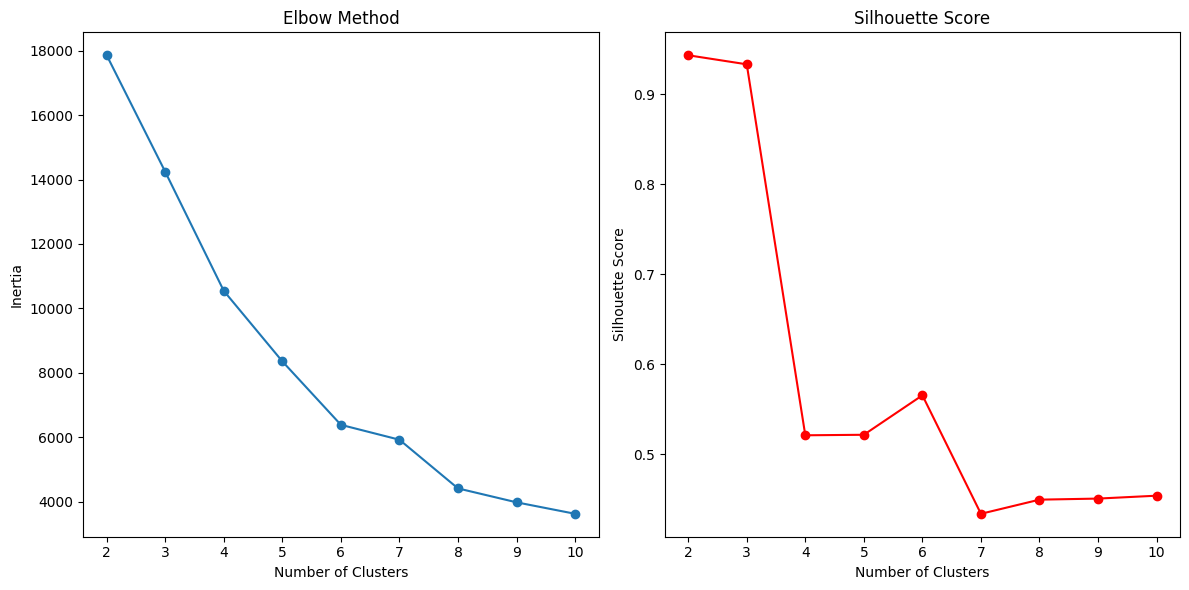

In [25]:
# Plot the Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='r')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



In [26]:
# Choose optimal number of clusters (e.g., 4 based on elbow method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_agg['Cluster'] = kmeans.fit_predict(customer_scaled)

# Show cluster centers
print("Cluster Centers: \n", kmeans.cluster_centers_)

Cluster Centers: 
 [[-6.41093480e-03  7.24204408e-02 -2.10775615e-02 -5.19212948e-01
   4.63695270e-02 -6.41093480e-03]
 [ 1.18741635e+01  9.20418543e+00  1.33337052e+00 -8.58870958e-01
   9.49799840e+00  1.18741635e+01]
 [ 8.35866818e+00 -4.25096503e-01  6.16388071e+01  2.33457414e+00
  -3.96577702e-01  8.35866818e+00]
 [-1.71292787e-01 -3.51158927e-01 -1.49809403e-02  1.51806453e+00
  -2.80085533e-01 -1.71292787e-01]]


Cluster Profiling

In [27]:
# Analyze the average characteristics of each cluster
cluster_profile = customer_agg.groupby('Cluster').mean()
print(cluster_profile)


           CustomerID     TotalSpend  TotalPurchases  AverageBasketSize  \
Cluster                                                                   
0        15280.647260    1997.078158        4.829701          19.706042   
1        15138.176471  108781.555294       75.117647        1649.509389   
2        12346.000000   77183.600000        1.000000       74215.000000   
3        15362.848375     514.731788        1.571300          27.023368   

            Recency    Frequency       Monetary  
Cluster                                          
0         39.582503   102.350872    1997.078158  
1          5.647059  2264.470588  108781.555294  
2        325.000000     1.000000   77183.600000  
3        243.253610    27.649819     514.731788  


# CLASSIFICATION MODELING

Prepare Data for Classification

In [28]:
# Prepare features (use features from customer_agg)
X = customer_agg[['TotalSpend', 'TotalPurchases', 'AverageBasketSize', 'Recency', 'Frequency', 'Monetary']]
y = customer_agg['Cluster']  # Target variable: customer segment (cluster)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train Classification Models

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train a RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report: \n", classification_report(y_test, y_pred))


Accuracy:  0.9942396313364056

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       628
           1       1.00      0.60      0.75         5
           3       0.99      1.00      0.99       235

    accuracy                           0.99       868
   macro avg       1.00      0.86      0.91       868
weighted avg       0.99      0.99      0.99       868



Hyperparameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters: ", grid_search.best_params_)
print("\nBest Cross-validation Accuracy: ", grid_search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Best Cross-validation Accuracy:  0.9959660817908942


## Train the XGBoost Model

In [31]:
from sklearn.model_selection import train_test_split

# Prepare features (use features from customer_agg)
X = customer_agg[['TotalSpend', 'TotalPurchases', 'AverageBasketSize', 'Recency', 'Frequency', 'Monetary']]
y = customer_agg['Cluster']  # Target variable: customer segment (cluster)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("\nClassification Report: \n", classification_report(y_test, y_pred))


Accuracy:  0.9919354838709677

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       628
           1       1.00      0.60      0.75         5
           3       0.99      0.99      0.99       235

    accuracy                           0.99       868
   macro avg       0.99      0.86      0.91       868
weighted avg       0.99      0.99      0.99       868



Hyperparameter Tuning with GridSearchCV

In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters: ", best_params)

# Predict with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Best Model Accuracy: ", accuracy_best)
print("\nBest Model Classification Report: \n", classification_report(y_test, y_pred_best))


AttributeError: 'super' object has no attribute '__sklearn_tags__'

Feature Importance

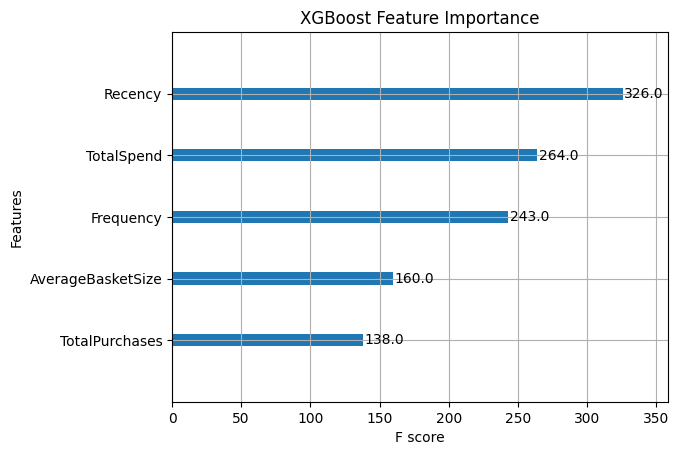

In [34]:
# Plot feature importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.show()
